In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as signal

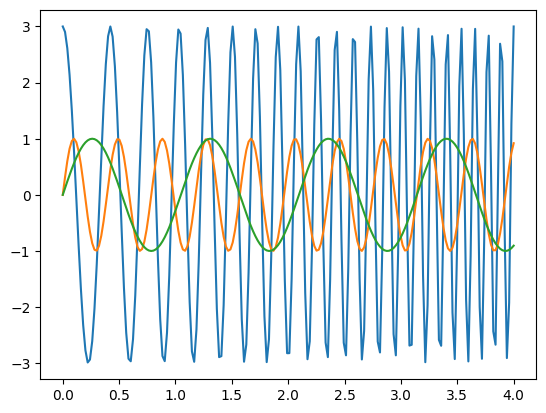

In [2]:
x = np.linspace(0, 4, 200)  # two second window at 50Hz
y1 = 3*signal.chirp(x, f0=2, f1=9, t1=4, method="linear")
#y1 = np.sin(x *10)
y2 = np.sin(x * 16) #See whats happens if phase changes and we add more time 
y3 = np.sin(x*6)
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

In [3]:
y_signal = y1+y2 + y3

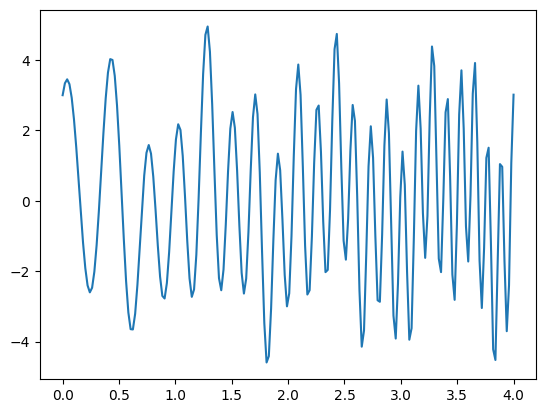

In [4]:
plt.plot(x, y_signal)

(0.0, 10.0)

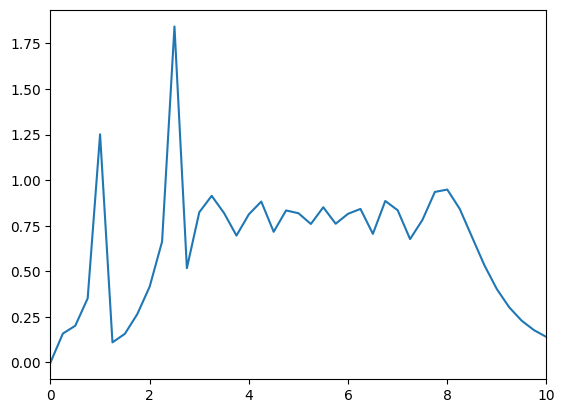

In [5]:
frequencies, powerspec = signal.periodogram(y_signal, 50)
plt.plot(frequencies, np.sqrt(powerspec))
plt.xlim(0, 10)

(0.0, 10.0)

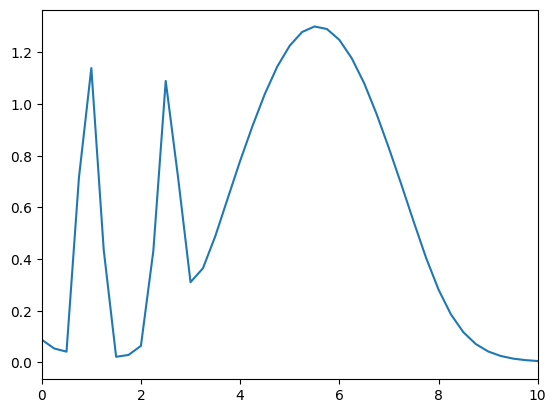

In [6]:
frequencies, powerspec = signal.periodogram(y_signal, 50, window='hann')
plt.plot(frequencies, np.sqrt(powerspec))
plt.xlim(0,10)

Hann versus non hann, gets rid of all signal!!!!!!!!!! CONCENING

(0.0, 8.0)

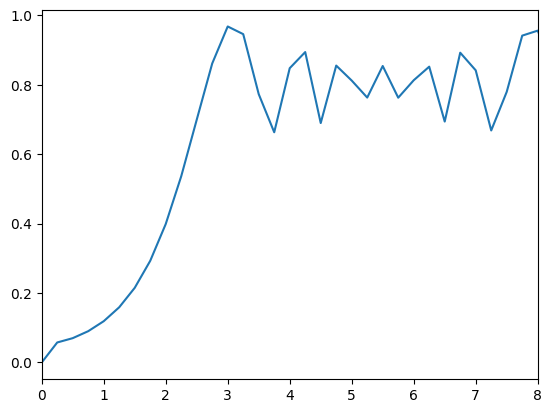

In [7]:
frequencies, powerspec = signal.periodogram(y1, 50)
plt.plot(frequencies, np.sqrt(powerspec))
plt.xlim(0, 8)

(0.0, 8.0)

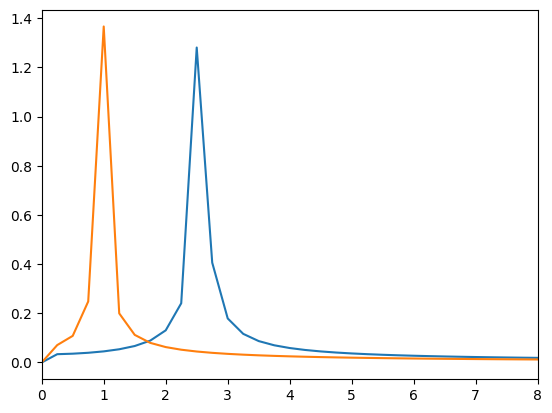

In [8]:
frequencies, powerspec = signal.periodogram(y2, 50)
plt.plot(frequencies, np.sqrt(powerspec))
frequencies, powerspec = signal.periodogram(y3, 50)
plt.plot(frequencies, np.sqrt(powerspec))
plt.xlim(0,8)

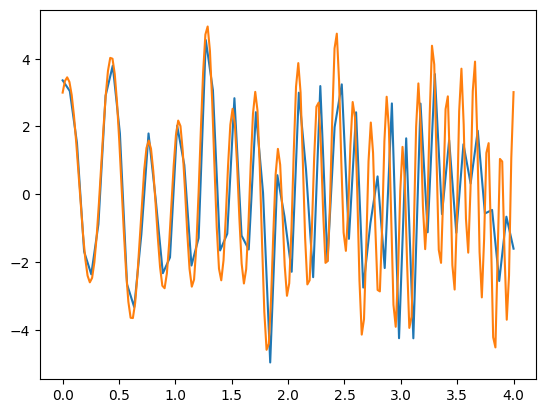

In [9]:
x_resampled = np.linspace(0, 4, 64)  # 50Hz to 16Hz, 32 inputs in a window, investigate phase lag look up other resampling methods
y_signal_resampled = signal.resample(y_signal, 64)
plt.plot(x_resampled,y_signal_resampled)
plt.plot(x, y_signal)

In [10]:
from numpy.typing import NDArray
x_resampled = np.linspace(0, 4, 64)

Clearly some aliasing

In [11]:
def sinc_interpolation(
    x: NDArray, s: NDArray, u: NDArray
) -> NDArray:  # https://gist.github.com/fschwar4/eb462151da065178144d53fe65e8c9fc
    """Whittaker–Shannon or sinc or bandlimited interpolation. 
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*)
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    Reference:
        This code is based on https://gist.github.com/endolith/1297227
        and the comments therein.
    TODO:
        * implement FFT based interpolation for speed up
    """
    sinc_ = np.sinc((u - s[:, None]) / (s[1] - s[0]))

    return np.dot(x, sinc_)

In [12]:
y_signal_sinc=sinc_interpolation(y_signal,x, x_resampled)

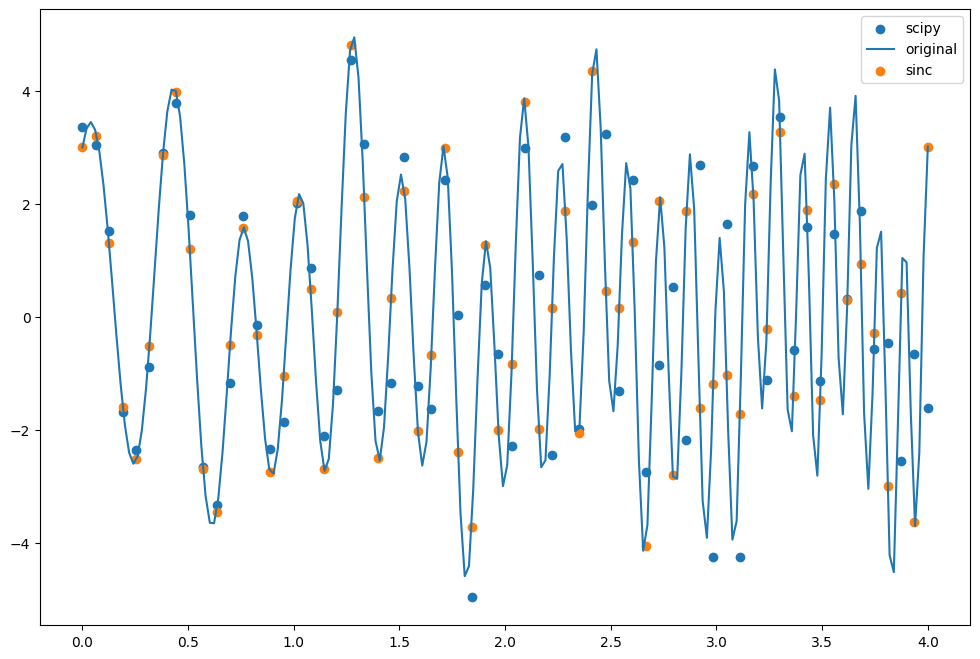

In [13]:
plt.figure(figsize=(12, 8))
y_signal_resampled = signal.resample(y_signal, 64)
plt.scatter(x_resampled, y_signal_resampled, label='scipy')
plt.plot(x, y_signal, label='original')
plt.scatter(x_resampled, y_signal_sinc, label='sinc')
plt.legend()

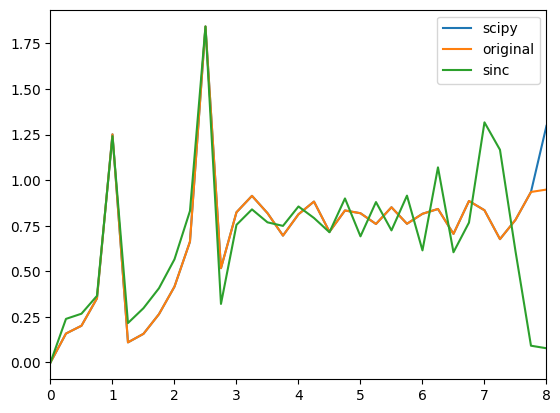

In [14]:
frequencies, powerspec = signal.periodogram(y_signal_resampled, 16)
plt.plot(frequencies, np.sqrt(powerspec), label="scipy")
frequencies, powerspec = signal.periodogram(y_signal, 50)
plt.plot(frequencies, np.sqrt(powerspec), label="original")
frequencies, powerspec = signal.periodogram(y_signal_sinc, 16)
plt.plot(frequencies, np.sqrt(powerspec), label="sinc")

plt.xlim(0, 8)
plt.legend()

Scipy preseves the fourier transform but does the works at matching the points which is the most important as we are interested in the $\frac{E}{B}$ ratio, Using the Shannon-Nyquit Theorm, it tells us the best digital resampling method for a signal is with sinc interpolation which is low-pass filtered to be below the Nyquist frequency

In [15]:
#Chirp providing higher frequencer, above 8, lets do a low pass filter on y signal

In [16]:
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype="low", analog=False)


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [17]:
a,b = butter_lowpass(7.5,50, 20) #https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units

In [18]:
plt.figure(figsize=(12, 6))


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Frequency [Hz]')

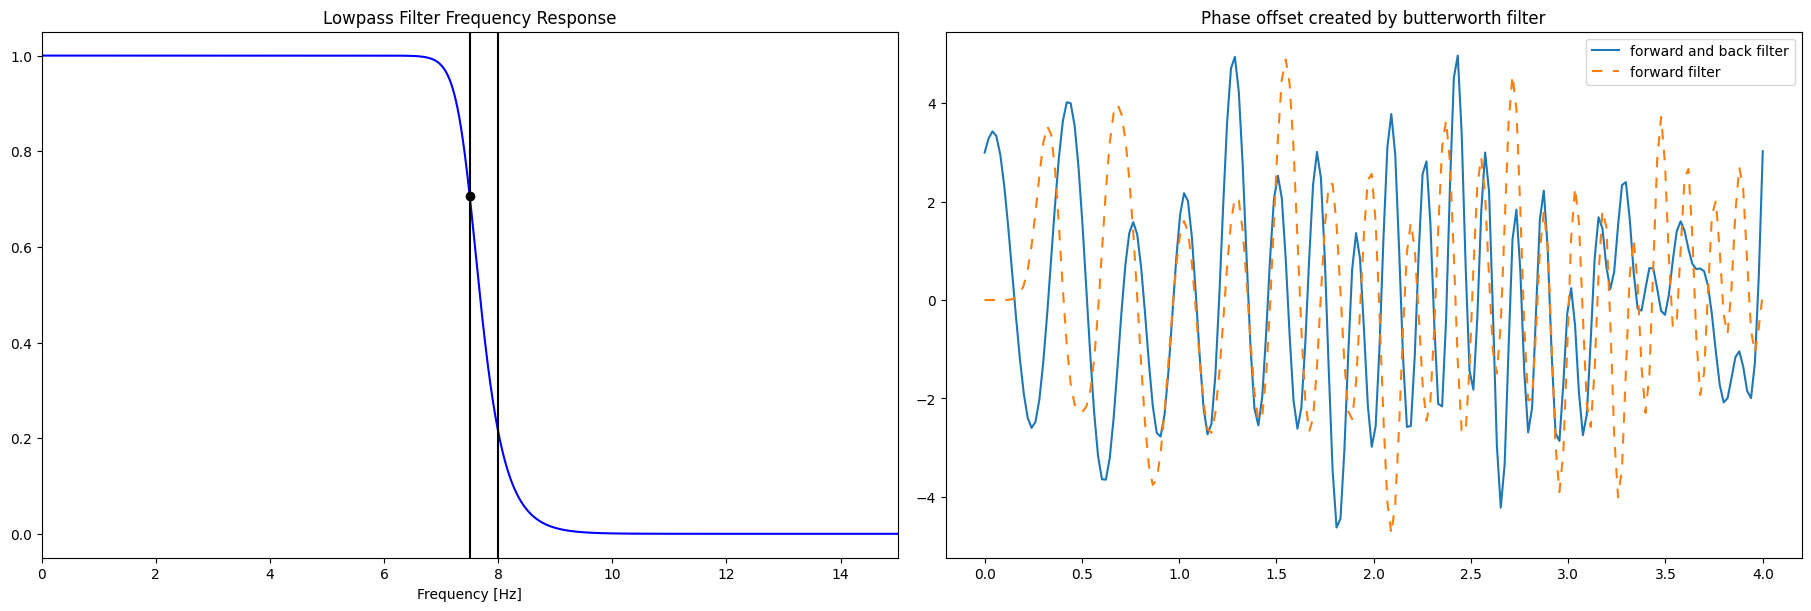

In [19]:
fig,ax=plt.subplots(figsize=(18, 6), constrained_layout=True, ncols=2)
y=signal.filtfilt(a,b,y_signal)
y_bad=butter_lowpass_filter(y_signal,7.5, 50, 20)
ax[1].plot(x,y, label= 'forward and back filter')
ax[1].plot(x,y_bad, "--",dashes=(5, 5), label='forward filter')
ax[1].set_title("Phase offset created by butterworth filter")
ax[1].legend()


w, h = freqz(a, b, fs=50, worN=8000)
ax[0].plot(w, np.abs(h), "b")
ax[0].plot(7.5, 0.5 * np.sqrt(2), "ko")
ax[0].axvline(7.5, color="k")
ax[0].axvline(8, color="k")
ax[0].set_xlim(0, 15)
ax[0].set_title("Lowpass Filter Frequency Response")
ax[0].set_xlabel("Frequency [Hz]")


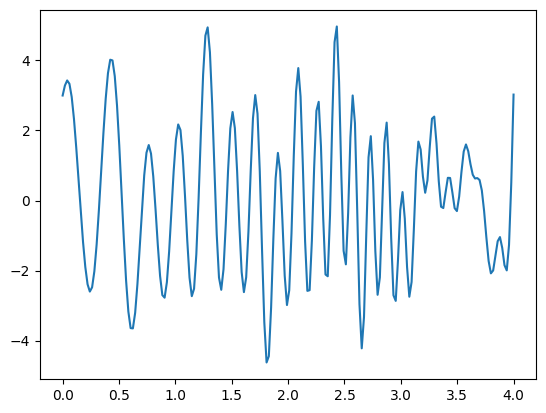

In [20]:
plt.plot(x,y)

(0.0, 8.0)

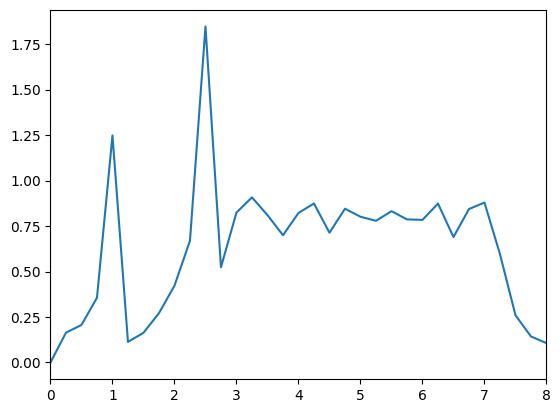

In [21]:
frequencies, powerspec = signal.periodogram(y, 50)
plt.plot(frequencies, np.sqrt(powerspec))
plt.xlim(0,8)

In [22]:
y_signal_sinc = sinc_interpolation(y, x, x_resampled)
y_signal_resampled=signal.resample(y, len(x_resampled))

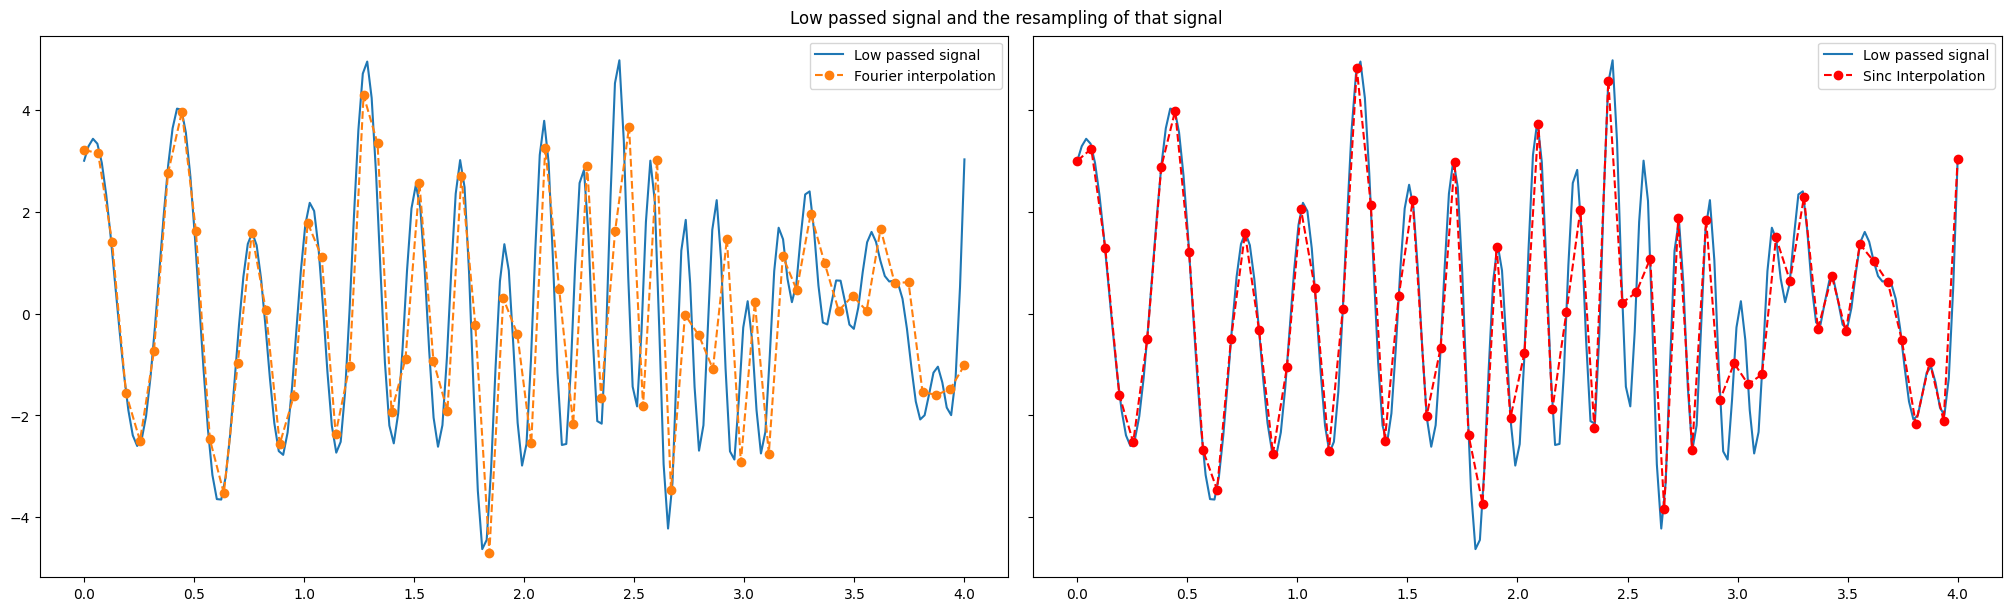

In [23]:
fig,ax=plt.subplots(figsize=(20, 6), ncols=2, sharex=True,sharey=True,constrained_layout=True)
ax[0].plot(x,y, label='Low passed signal')
ax[1].plot(x,y, label='Low passed signal')
ax[0].plot(x_resampled, y_signal_resampled, "--o", label='Fourier interpolation')
ax[1].plot(x_resampled, y_signal_sinc, "--o", label='Sinc Interpolation', color='red')
fig.suptitle("Low passed signal and the resampling of that signal")
ax[0].legend()
ax[1].legend()

In [24]:
print(len(y_signal_sinc))

64


c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


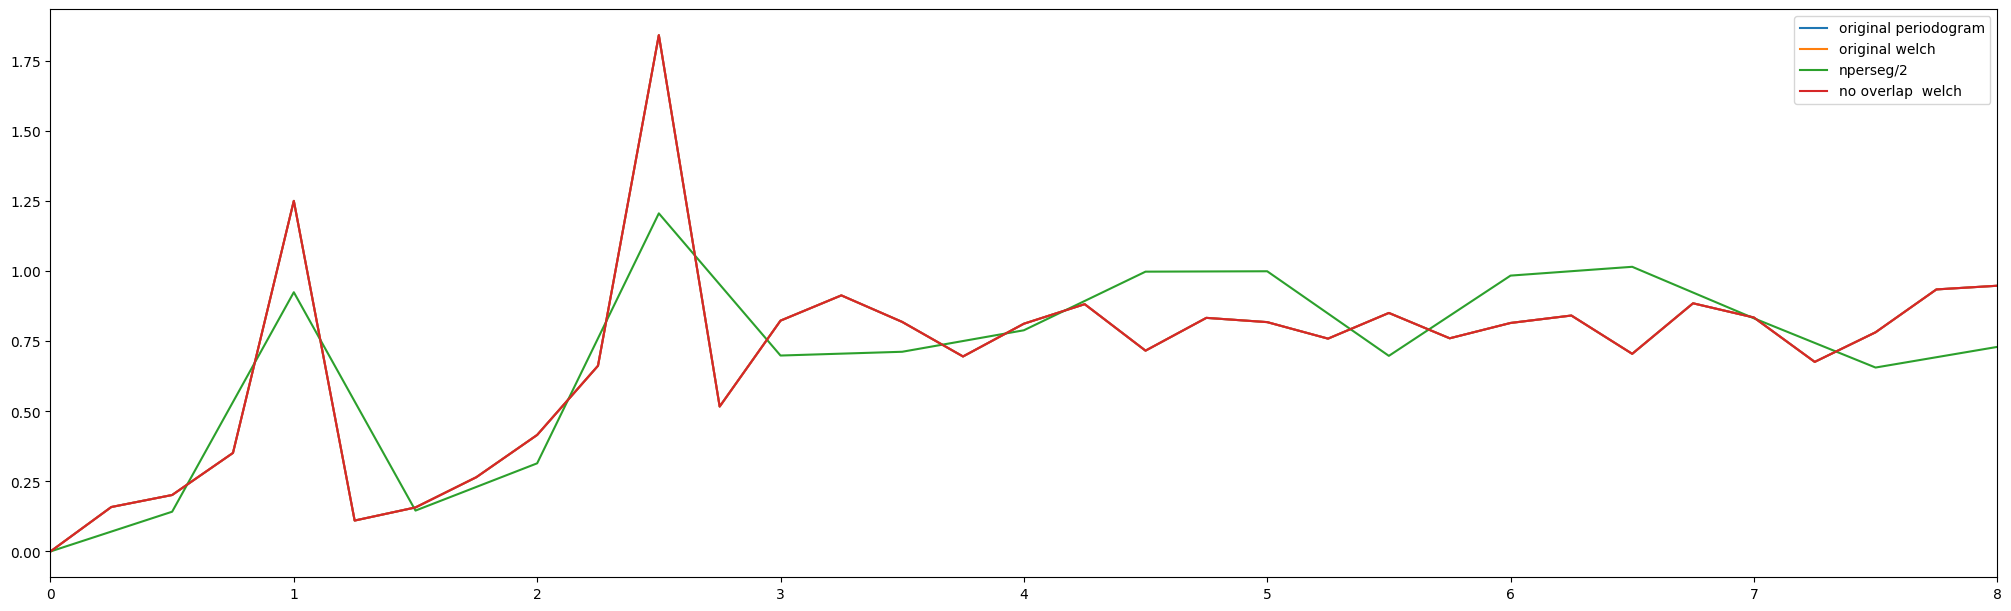

In [25]:
fig,ax=plt.subplots(figsize=(20, 6),constrained_layout=True)
frequencies, powerspec = signal.periodogram(y_signal, 50)
plt.plot(frequencies, np.sqrt(powerspec), label="original periodogram")
frequencies, psd = signal.welch(y_signal, 50, window='boxcar')
plt.plot(frequencies, np.sqrt(psd), label="original welch")
frequencies, psd = signal.welch(y_signal, 50, window='boxcar', nperseg=len(y_signal)/2)
plt.plot(frequencies, np.sqrt(psd), label="nperseg/2")
frequencies, psd = signal.welch(y_signal, 50, window='boxcar', noverlap=0)
plt.plot(frequencies, np.sqrt(psd), label="no overlap  welch")

plt.xlim(0, 8)
plt.legend()

A good reference for the performance of Welch's method for Power Spectral Density (PSD) estimation can be found in this report by Solomon.

Welch's method involves the averaging of multiple periodograms (PSD estimates) from, potentially overlapping, segments of data. This method is beneficial because the noise from multiple periodograms gets "averaged out," though at a trade-off of decreased frequency resolution from shorter segment lengths. The larger nperseg (number of samples per segment) is, the fewer segments or averages you can take and the higher frequency resolution you get. Conversely, the smaller nperseg is, the better noise rejection you get but with lower frequency resolution.

As mentioned in the Solomon's report, the noise cancelling effect is most effective when the periodograms being averaged are independent of each other. If you select the noverlap argument of signal.welch to be large (e.g. nperseg - 1), two adjacent periodograms will be highly correlated and thus not very independent.

From page 8 of Solomon's report:

Ideally S
, the number of samples to shift between segments, should be the smallest value such that the Xk(ν)
 and Xk+1(ν)
 are nearly uncorrelated. This value of S
 would save arithmetic operations but provide the maximum amount of smoothing. The shift between segments, S
, is usually in the range of 0.4M≤S≤M
.

where M=
nperseg and Xk(ν)
 is the discrete Fourier transform value of the k
th segment. So to answer your question:

Is it valid to compute PSD overlapping data (for instance data chunk of 2 seconds, but overlapping 1 sec) ?

Yes, it can be valid to perform PSD estimation using overlapping segments. How much overlap between segments you should use depends on how correlated your data is in time. By default, Scipy sets noverlap=nperseg // 2 because a 50% overlap is commonly employed and is probably sufficient for most problems, but one cannot say that this is necessarily the ideal overlap for your case. If you know your data can be modeled as a moving average model, then your largest correlation lag is simply the order of that model.

If you don't know anything about your data, an overlap of 50% can be a reasonable estimate, but be aware that it is only an estimate and likely differs from the true PSD. The same argument could be made for 0% overlap. Make sure to select a segment length nperseg that gives you an adequate frequency resolution for your analysis. https://dsp.stackexchange.com/questions/81640/trying-to-understand-the-nperseg-effect-of-welch-method

c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\scipy\signal\_spectral_py.py:2017: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  warnings.warn('nperseg = {0:d} is greater than input length '


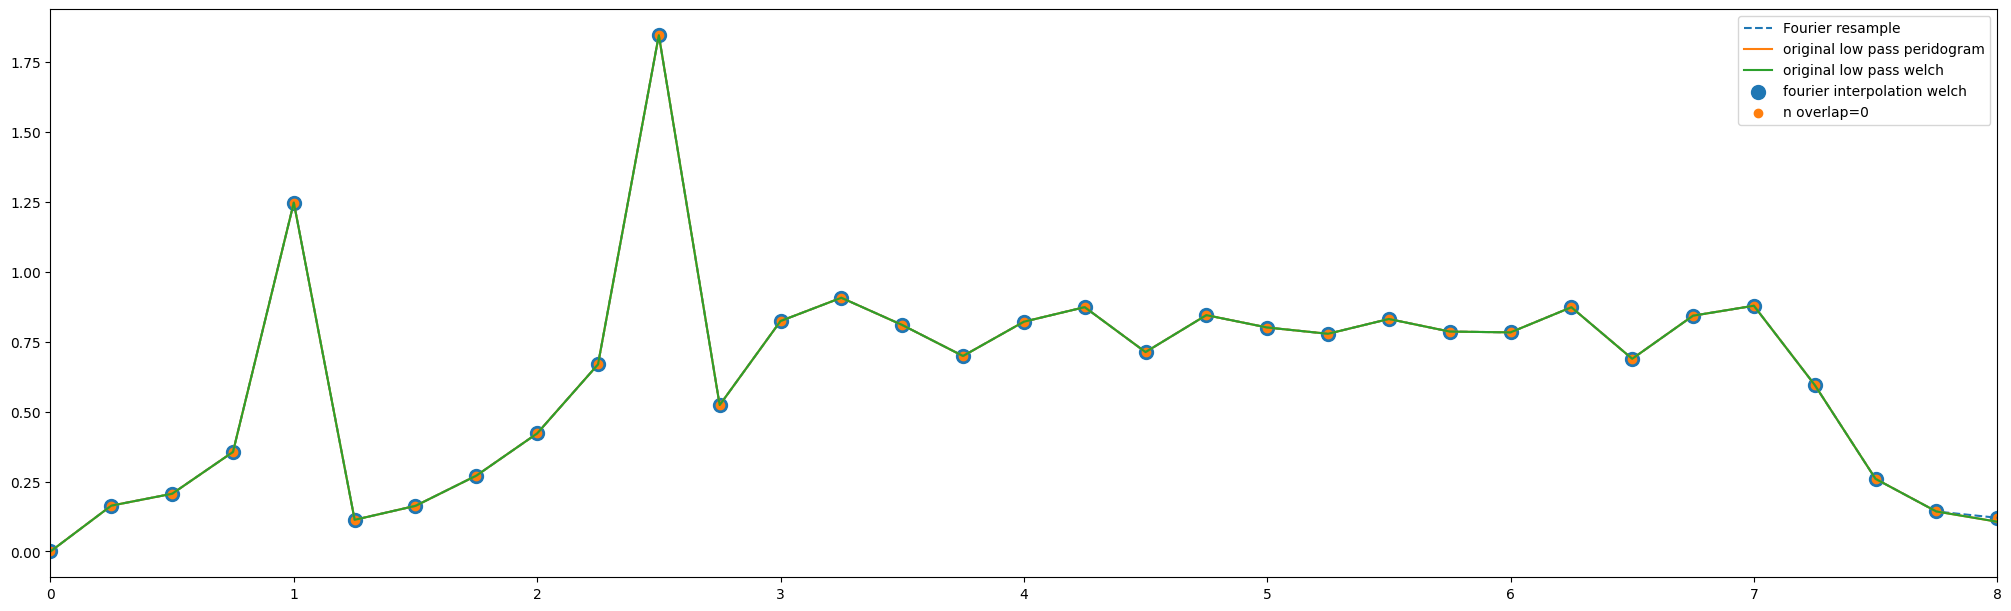

In [26]:
fig,ax=plt.subplots(figsize=(20, 6),constrained_layout=True)
frequencies, powerspec = signal.periodogram(y_signal_resampled, 16)
plt.plot(frequencies, np.sqrt(powerspec), label="Fourier resample", linestyle='dashed')
frequencies, powerspec = signal.periodogram(y, 50)
plt.plot(frequencies, np.sqrt(powerspec), label="original low pass peridogram")
frequencies, psd = signal.welch(y, 50, window='boxcar')
plt.plot(frequencies, np.sqrt(psd), label="original low pass welch")
frequencies, psd = signal.welch(y_signal_resampled, 16, window='boxcar')
plt.scatter(frequencies, np.sqrt(psd), label="fourier interpolation welch", s=100)
frequencies, psd = signal.welch(y_signal_resampled, 16, window='boxcar', noverlap=0)
plt.scatter(frequencies, np.sqrt(psd), label="n overlap=0")
plt.xlim(0, 8)
plt.legend()

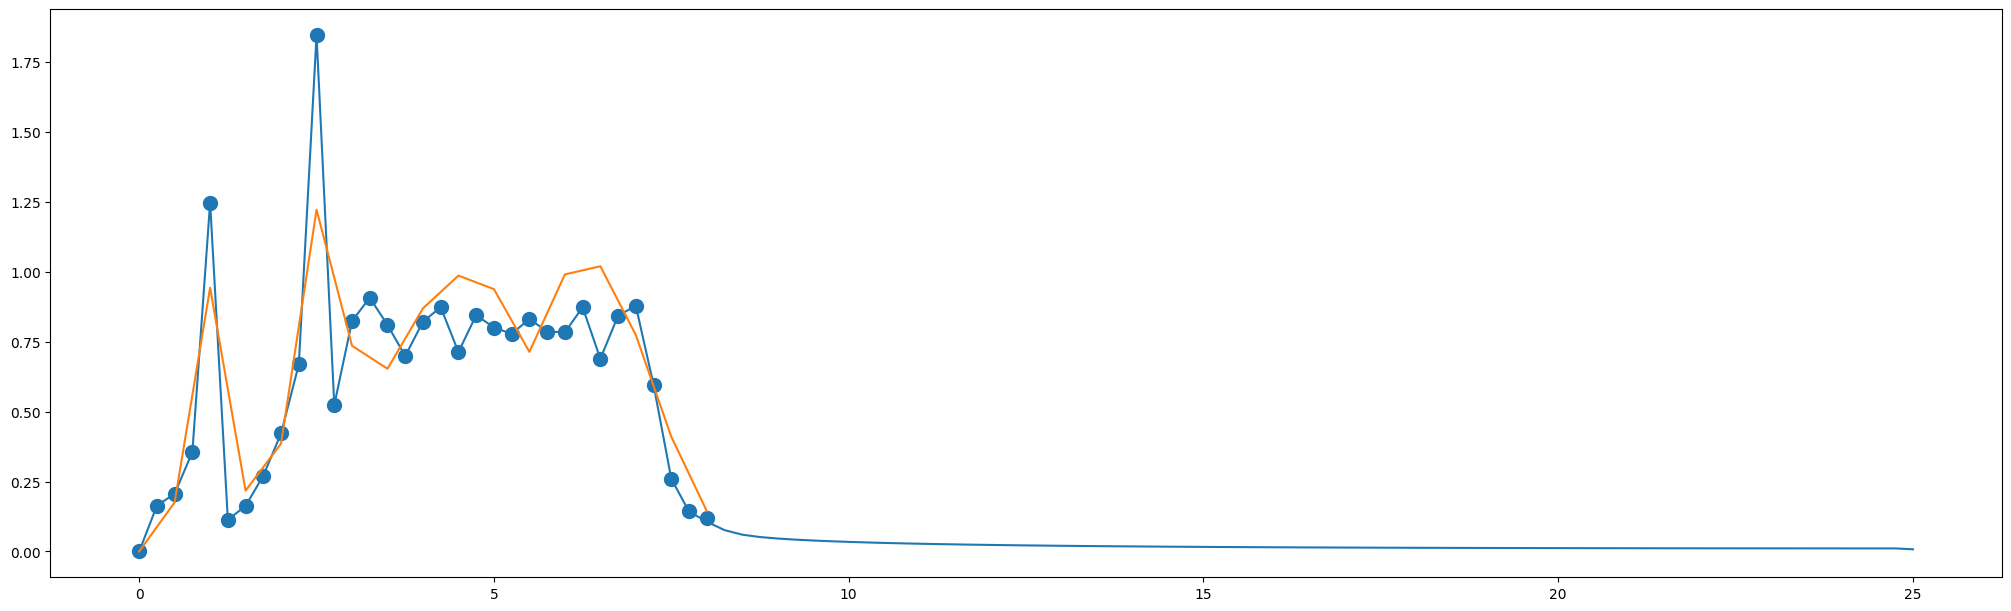

In [27]:
fig,ax=plt.subplots(figsize=(20, 6),constrained_layout=True)
frequencies, psd = signal.welch(y, 50, window='boxcar')
plt.plot(frequencies, np.sqrt(psd), label="original low pass welch")
frequencies, psd = signal.welch(y_signal_resampled, 16, window='boxcar')
plt.scatter(frequencies, np.sqrt(psd), label="fourier interpolation welch", s=100)
frequencies, psd = signal.welch(y_signal_resampled, 16, window='boxcar', nperseg=32)
plt.plot(frequencies, np.sqrt(psd), label="fourier interpolation welch")


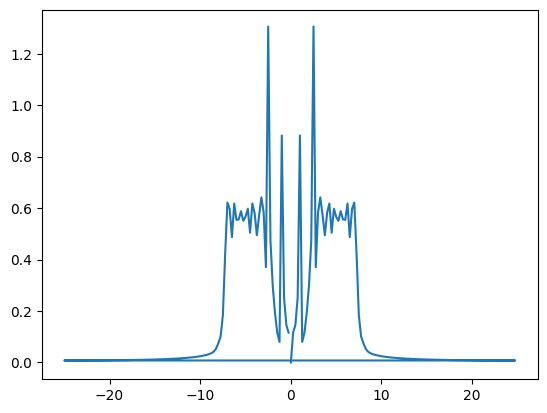

In [28]:
frequencies, psd = signal.welch(y, 50, window='boxcar', return_onesided=False)
plt.plot(frequencies, np.sqrt(psd), label="original low pass welch")

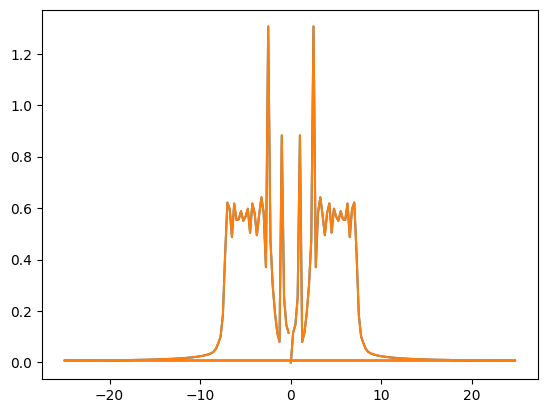

In [29]:
frequencies, psd = signal.csd(y,y ,  50, window='boxcar', return_onesided=False)
plt.plot(frequencies, np.sqrt(psd), label="csd")
frequencies, psd = signal.welch(y, 50, window='boxcar', return_onesided=False)
plt.plot(frequencies, np.sqrt(psd), label="original low pass welch")

c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


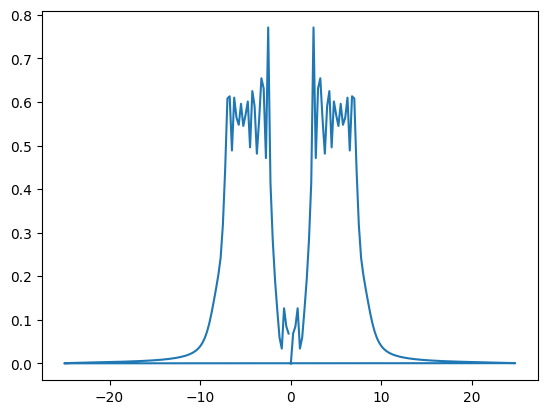

In [30]:
frequencies, psd = signal.csd(y,y1 ,  50, window='boxcar', return_onesided=False)
plt.plot(frequencies, np.sqrt(psd), label="csd")

In [31]:
import numpy as np

# Create a numpy datetime array with nanosecond precision
datetime_array = np.array(['2024-06-10T10:00:00.000000000', '2024-06-10T12:00:00.000000000'], dtype='datetime64[ns]')

# Add two seconds
two_seconds = np.timedelta64(2, 's')
new_datetime_array = datetime_array + two_seconds

print(new_datetime_array)

['2024-06-10T10:00:02.000000000' '2024-06-10T12:00:02.000000000']


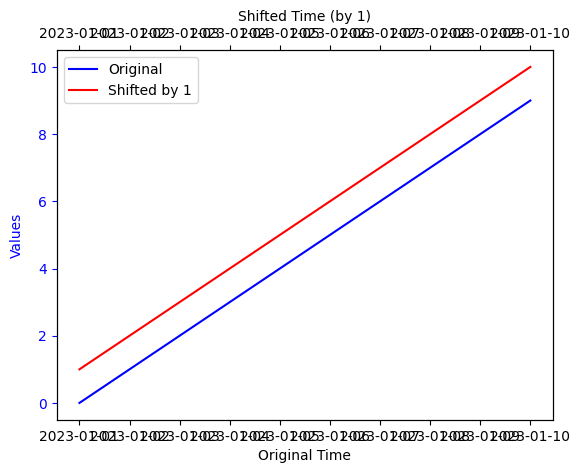

: 

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
time = pd.date_range(start='2023-01-01', periods=10, freq='D')
values = range(10)
shifted_values = range(1, 11)  # shifted by 1

# Plot the original time series
fig, ax1 = plt.subplots()

ax1.plot(time, values, 'b-', label='Original')
ax1.set_xlabel('Original Time')
ax1.set_ylabel('Values', color='b')
ax1.tick_params('y', colors='b')

# Create a twin x-axis to show the shifted time series
ax2 = ax1.twiny()
ax2.plot(time, shifted_values, 'r-', label='Shifted by 1')
ax2.set_xlabel('Shifted Time (by 1)')

# To align the secondary x-axis correctly, set its limits to match the primary x-axis limits
ax2.set_xlim(ax1.get_xlim())

# Optional: add legends to indicate which line corresponds to which axis
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.show()